# Data preparation from Chapter 02

In [18]:
import sys
from packaging import version

# Download the Data
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

# Create a Test Set
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import binom
from sklearn.model_selection import StratifiedShuffleSplit

# Looking for Correlations
from pandas.plotting import scatter_matrix

# Data Cleaning
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# Handling Text and Categorical Attributes
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

# Custom Transformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

# Transformation Pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

# Training and Evaluating on the Training Set
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Better Evaluation Using Cross-Validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Fine-Tune Your Model
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, geom, expon
from scipy.stats import loguniform

# Evaluate Your System on the Test Set
from scipy import stats

# Model persistence using joblib
import joblib

########
from sklearn.svm import SVR

In [19]:
set_config(display='diagram')

In [20]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [21]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [22]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [23]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [24]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

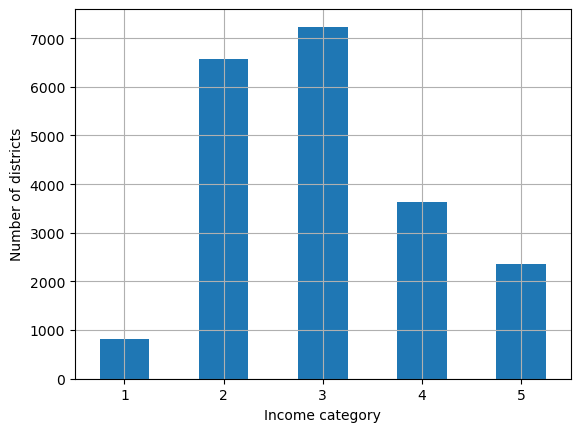

In [26]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [27]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [29]:
housing = strat_train_set.copy()

In [30]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [31]:
housing_num = housing.select_dtypes(include=[np.number])

In [32]:
housing_cat = housing[["ocean_proximity"]]

In [33]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [34]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [35]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [36]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

In [37]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E1F0C8D400>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E1F06BCC70>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [38]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [39]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41385.520595938855


# Exercises

## 1.

In [42]:
full_pipeline_E1 = Pipeline([
    ("preprocessing", preprocessing),
    ("SVR", SVR()),
])
param_grid_E1 = [
    {'SVR__kernel': ['rbf'],
     'SVR__C': [0.1, 0.7, 1.0, 1.2, 2.0],
     'SVR__gamma': [0.01, 0.07, 0.10, 0.12, 2.0]},
    {'SVR__kernel': ['linear'],
     'SVR__C': [0.1, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6, 2.0]},
]
grid_search_E1 = GridSearchCV(full_pipeline_E1, param_grid_E1, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search_E1.fit(housing.iloc[:5000 , :], housing_labels[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E1F0C8B130>)])),
                                       ('SVR', SVR())]),
             param_grid=[{'SVR__C': [0.1, 0.7, 1.0, 1.2, 2.0],
                          'SVR__gamma': [0.01, 0.07, 0.1, 0.12, 2.0],
                          'SVR__kernel': ['rbf']},
                         {'SVR__C': [0.1, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6, 2.0],
                          'SVR__kernel': ['linear']}],
             scoring='neg_root_mean_squared_error')

In [43]:
grid_search_E1.best_params_

{'SVR__C': 2.0, 'SVR__kernel': 'linear'}

In [44]:
grid_search_E1.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001E...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E1F2A74160>)])),
                ('SVR', SVR(C=2.0, kernel='linear'))])

In [45]:
grid_search_E1.cv_results_

{'mean_fit_time': array([1.67307679, 1.67656255, 1.65416781, 1.75322382, 1.6353391 ,
        1.6504883 , 1.73790399, 1.86108295, 1.93566966, 1.70237549,
        1.76566354, 1.75221904, 1.68290273, 1.67665291, 1.65805276,
        1.68280729, 1.68794608, 1.67685215, 1.68517367, 1.63738966,
        1.6795671 , 1.67501346, 1.66541664, 1.6645515 , 1.65950886,
        1.62756054, 1.61285075, 1.58153534, 1.59923251, 1.61982648,
        1.58611989, 1.56428623, 1.57132165]),
 'std_fit_time': array([0.0262547 , 0.02255997, 0.00180136, 0.10235996, 0.00249682,
        0.00447333, 0.05250202, 0.18899707, 0.31589537, 0.05340309,
        0.04249723, 0.03668555, 0.00338795, 0.00317409, 0.00879627,
        0.00068694, 0.0133802 , 0.00607707, 0.01323169, 0.01703417,
        0.01691138, 0.01416471, 0.01438657, 0.0084996 , 0.02332857,
        0.03388445, 0.02703406, 0.00915778, 0.0082509 , 0.00933818,
        0.00756147, 0.00102993, 0.01268434]),
 'mean_score_time': array([1.15504567, 1.17942683, 1.143845

In [46]:
cv_res_E1 = pd.DataFrame(grid_search_E1.cv_results_)
cv_res_E1.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [76]:
cv_res_E1.head

<bound method NDFrame.head of     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
32       1.571322      0.012684         0.744734        0.005874   
31       1.564286      0.001030         0.736567        0.008638   
30       1.586120      0.007561         0.746690        0.004246   
29       1.619826      0.009338         0.759136        0.012138   
28       1.599233      0.008251         0.751561        0.008480   
27       1.581535      0.009158         0.744618        0.005402   
26       1.612851      0.027034         0.746098        0.010762   
25       1.627561      0.033884         0.745339        0.013391   
21       1.675013      0.014165         1.165839        0.021996   
22       1.665417      0.014387         1.153795        0.004959   
23       1.664551      0.008500         1.156246        0.012960   
16       1.687946      0.013380         1.178973        0.017424   
17       1.676852      0.006077         1.166806        0.004497   
18       1.685174 

In the range of values given, the results for the Support Vector Regressor are much worse than those obtained in the chapter by using Random Forest.
The best present result has an RMSE: 116,097, which is much higher than the 41,385 of the RF model.

## 2.

In [82]:
full_pipeline_E2 = Pipeline([
    ("preprocessing", preprocessing),
    ("SVR", SVR()),
])
param_distribs_E2 = [
    {'SVR__kernel': ['rbf'],
     'SVR__C': uniform(0.01, 2),
     'SVR__gamma': uniform(0.01, 2)},
    {'SVR__kernel': ['linear'],
     'SVR__C': uniform(0.01, 2)},
]
rnd_search_E2 = RandomizedSearchCV(full_pipeline_E2, param_distribs_E2, n_iter=10, cv=3,
                           scoring='neg_root_mean_squared_error', random_state=42)
rnd_search_E2.fit(housing.iloc[:5000 , :], housing_labels[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                   param_distributions=[{'SVR__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1F0C8B520>,
                                         'SVR__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1F0D0B1C0>,
                                         'SVR__kernel': ['rbf']},
                                        {'SVR__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001E1F2A50FA0>,
                                         'SVR__kernel': ['linear']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [84]:
rnd_search_E2.best_params_

{'SVR__C': 1.3117769458977058, 'SVR__kernel': 'linear'}

In [86]:
rnd_search_E2.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001E...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E1F2A4CA60>)])),
                ('SVR', SVR(C=1.3117769458977058, kernel='linear'))])

In [88]:
rnd_search_E2.cv_results_

{'mean_fit_time': array([1.68780073, 1.5644691 , 1.73544145, 1.69952297, 1.63403853,
        1.66518585, 1.71580712, 1.77735035, 1.5951031 , 1.65176066]),
 'std_fit_time': array([0.05762093, 0.00701957, 0.07406714, 0.01635047, 0.06139911,
        0.02166259, 0.13109113, 0.09484653, 0.01848906, 0.01148887]),
 'mean_score_time': array([1.18479069, 0.73304582, 1.19097376, 1.20813084, 0.75763289,
        1.18018087, 0.79339035, 0.76587669, 0.74632247, 1.14729691]),
 'std_score_time': array([0.04099651, 0.00453781, 0.03385757, 0.07299673, 0.03077627,
        0.02976556, 0.04619015, 0.01717623, 0.00616014, 0.01090675]),
 'param_SVR__C': masked_array(data=[1.6030859737204657, 1.2073169683940732,
                    0.9016655057071823, 1.7423522915498704,
                    1.3117769458977058, 1.9498197043239887,
                    0.011557531682028657, 0.37680901970686764,
                    1.2333063209765618, 0.8738900372842315],
              mask=[False, False, False, False, False, Fal

In [90]:
cv_res_E2 = pd.DataFrame(rnd_search_E2.cv_results_)
cv_res_E2.sort_values(by="mean_test_score", ascending=False, inplace=True)

In [92]:
cv_res_E2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVR__C,param_SVR__gamma,param_SVR__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,1.634039,0.061399,0.757633,0.030776,1.311777,NaN,linear,"{'SVR__C': 1.3117769458977058, 'SVR__kernel': ...",-117968.562415,-120030.049745,-113943.563648,-117314.058603,2527.529714,1
8,1.595103,0.018489,0.746322,0.006160,1.233306,NaN,linear,"{'SVR__C': 1.2333063209765618, 'SVR__kernel': ...",-118069.406588,-120172.897695,-114065.688521,-117435.997601,2533.167475,2
1,1.564469,0.007020,0.733046,0.004538,1.207317,NaN,linear,"{'SVR__C': 1.2073169683940732, 'SVR__kernel': ...",-118125.667755,-120214.231997,-114116.038561,-117485.312771,2530.419158,3
7,1.777350,0.094847,0.765877,0.017176,0.376809,NaN,linear,"{'SVR__C': 0.37680901970686764, 'SVR__kernel':...",-119695.218082,-121836.439205,-115571.770225,-119034.475837,2599.865970,4
2,1.735441,0.074067,1.190974,0.033858,0.901666,0.20995,rbf,"{'SVR__C': 0.9016655057071823, 'SVR__gamma': 0...",-120384.426765,-122606.043008,-116232.736788,-119741.068854,2641.362034,5


In this situation, the results (117,314) doesn't change very much from the previous calculations (116,097). But it is worth mention that the RandomizedSearchCV() was much faster than GridSearchCV().

## 3.

## 4.

## 5.